### Binary classification about diagnosing AIDS.

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append("..")
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("../Data/AIDS_Classification.csv", delimiter=",", skip_header=1)
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data, grid_search: bool=False):
  if grid_search:
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=0)
  else:
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test_raw, dtype=torch.float32, device=device).reshape(-1, 1)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  23
Number of datapoints:  2139


In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, loops, grid_search: bool=False):
    model.to(device=device)
    acc_lst = np.zeros(loops)
    f1_lst = np.zeros(loops)

    for i in range(loops):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data, grid_search)
        loss_fn = nn.BCEWithLogitsLoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=100, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        model.eval()
        y_pred = model(X_test)
        y_pred_prob = torch.sigmoid(y_pred)
        y_pred_binary = (y_pred_prob > 0.5).float().cpu().detach()
        acc = accuracy_score(y_test.cpu(), y_pred_binary)
        acc_lst[i] = float(acc)
        f1 = f1_score(y_test.cpu(), y_pred_binary)
        f1_lst[i] = float(f1)
        # print("Accuracy:", float(acc))
        # print("F1-score:", float(f1))
    return acc_lst, f1_lst

## Grid search

In [3]:
from itertools import product
import pandas as pd


param_grid = {
  'num_pit_samples': [50, 100, 150, 250, 500, 1000],
  'take_num_samples_when_full': [0, 1, 2, 3, 5, 10],
  'normal_backtransform': [True, False],
  'trainable_bandwidths': [True, False]
}

best_f1_4 = -np.inf
best_params_4 = None
best_f1_5 = -np.inf
best_params_5 = None
best_f1_6 = -np.inf
best_params_6 = None

/tmp/ipykernel_275549/1628494113.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
result = np.array(["accuracy", "f1", "num_pit_samples", "take_num_samples_when_full", "normal_backtransform", "trainable_bandwidths", "model_id"])
for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
 
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model4 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 50),
    nn.ReLU(),
    nn.Linear(50, 80),
    BatchPitNorm1d(num_features=80, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(80, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
  model4.to(device=device)
  try:
    acc_4, f1_4 = train_model(model4, 1, True)
    if np.mean(f1_4) > np.mean(best_f1_4):
      best_acc_4 = acc_4
      best_f1_4 = f1_4
      best_params_4 = params

    values = np.array([np.mean(acc_4), np.mean(f1_4), num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths, "model 4"])
    result = np.vstack((result, values))
  except Exception as e: 
    print(e)
    df = pd.DataFrame(result)
    df.to_csv("aids4.csv", index=False)
    break

print(f"Model 4: Best params: {best_params_4} with accuracy: {np.mean(best_acc_4)}, F1-score: {np.mean(best_f1_4)}")
df = pd.DataFrame(result)
df.to_csv("aids4.csv", index=False)


num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=2, normal_backtran

In [5]:
result = np.array(["accuracy", "f1", "num_pit_samples", "take_num_samples_when_full", "normal_backtransform", "trainable_bandwidths", "model_id"])
for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
 
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model5 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 50),
    BatchPitNorm1d(num_features=50, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(50, 80),
    nn.ReLU(),
    nn.BatchNorm1d(80),
    nn.Linear(80, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
  model5.to(device=device)
  
  try:
    acc_5, f1_5 = train_model(model5, 1, True)
    if np.mean(f1_5) > np.mean(best_f1_5):
      best_acc_5 = acc_5
      best_f1_5 = f1_5
      best_params_5 = params
    values = np.array([np.mean(acc_5), np.mean(f1_5), num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths, "model 5"])
    result = np.vstack((result, values))
  except Exception as e: 
    print(e)
    df = pd.DataFrame(result)
    df.to_csv("aids5.csv", index=False)
    break
  
print(f"Model 5: Best params: {best_params_5} with accuracy: {np.mean(best_acc_5)}, F1-score: {np.mean(best_f1_5)}")
df = pd.DataFrame(result)
df.to_csv("aids5.csv", index=False)

num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=2, normal_backtran

In [15]:
result = np.array(["accuracy", "f1", "num_pit_samples", "take_num_samples_when_full", "normal_backtransform", "trainable_bandwidths", "model_id"])
for params in product(*param_grid.values()):
  num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths = params
 
  print(f"num_pit_samples={num_pit_samples}, take_num_samples_when_full={take_num_samples_when_full},"+
        f" normal_backtransform={normal_backtransform}, trainable_bandwidths={trainable_bandwidths}")

  model6 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 50),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(50, 10),
    BatchPitNorm1d(num_features=10, num_pit_samples=num_pit_samples, take_num_samples_when_full=take_num_samples_when_full,
                    normal_backtransform=normal_backtransform, trainable_bandwidths=trainable_bandwidths, bw_select = "RuleOfThumb", dev=device),
    nn.ReLU(),
    nn.Linear(10, 1))
  model6.to(device=device)
  
  try:
    acc_6, f1_6 = train_model(model6, 1, True)
    if np.mean(f1_6) > np.mean(best_f1_6):
      best_acc_6 = acc_6
      best_f1_6 = f1_6
      best_params_6 = params
    values = np.array([np.mean(acc_6), np.mean(f1_6), num_pit_samples, take_num_samples_when_full, normal_backtransform, trainable_bandwidths, "model 6"])
    result = np.vstack((result, values))
  except Exception as e: 
    print(e)
    df = pd.DataFrame(result)
    df.to_csv("aids6.csv", index=False)
    break
  
print(f"Model 6: Best params: {best_params_6} with accuracy: {np.mean(best_acc_6)}, F1-score: {np.mean(best_f1_6)}")
df = pd.DataFrame(result)
df.to_csv("aids6.csv", index=False)

num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=0, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=True, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=1, normal_backtransform=False, trainable_bandwidths=False
num_pit_samples=50, take_num_samples_when_full=2, normal_backtransform=True, trainable_bandwidths=True
num_pit_samples=50, take_num_samples_when_full=2, normal_backtran

## Comparison

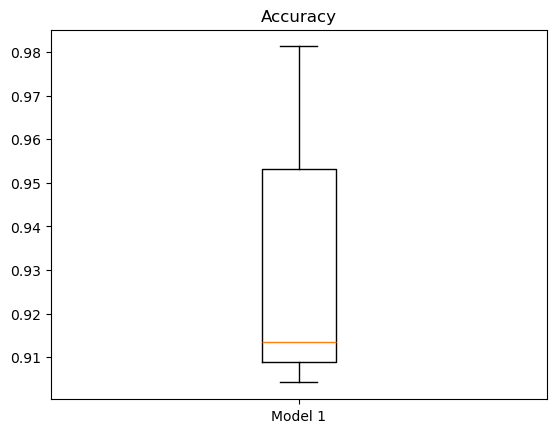

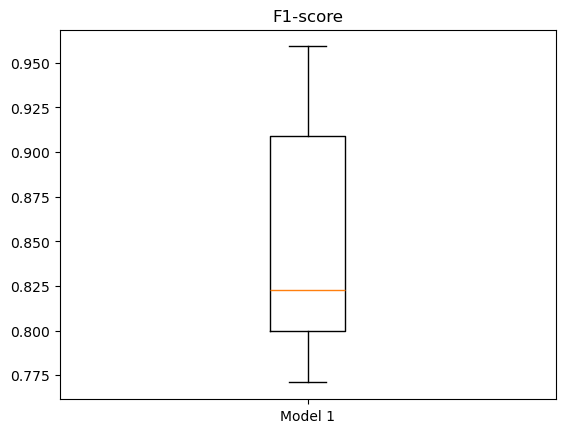

In [16]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model1.to(device=device)

acc1, f1_1 = train_model(model1, 5)

plt.boxplot(acc1, labels=["Model 1"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_1, labels=["Model 1"])
plt.title("F1-score")
plt.show()

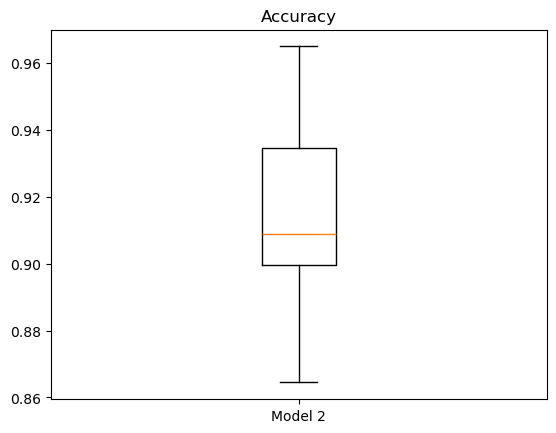

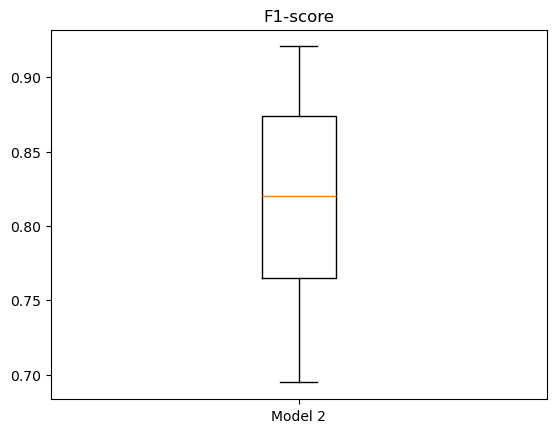

In [17]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1))
model2.to(device=device)

acc2, f1_2 = train_model(model2, 5)

plt.boxplot(acc2, labels=["Model 2"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_2, labels=["Model 2"])
plt.title("F1-score")
plt.show()

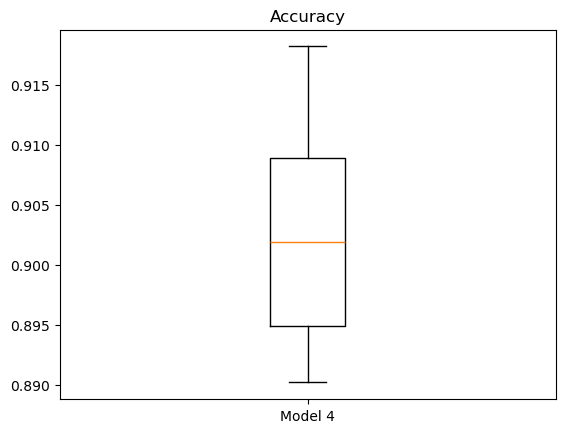

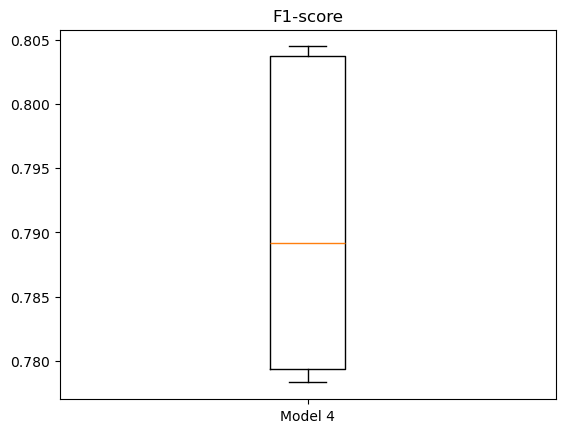

In [18]:
model4 = nn.Sequential(
  nn.Linear(data.shape[1]-1, 50),
  nn.ReLU(),
  nn.Linear(50, 80),
  BatchPitNorm1d(num_features=80, num_pit_samples=150, take_num_samples_when_full=2,
                  normal_backtransform=False, trainable_bandwidths=False, bw_select = "RuleOfThumb", dev=device),
  nn.ReLU(),
  nn.Linear(80, 10),
  nn.ReLU(),
  nn.Linear(10, 1))
model4.to(device=device)

acc4, f1_4 = train_model(model4, 5)

plt.boxplot(acc4, labels=["Model 4"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_4, labels=["Model 4"])
plt.title("F1-score")
plt.show()

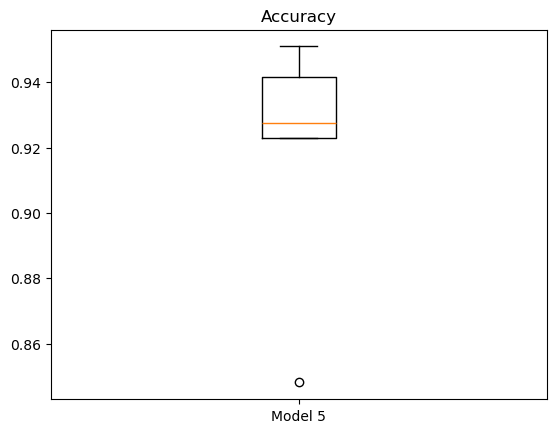

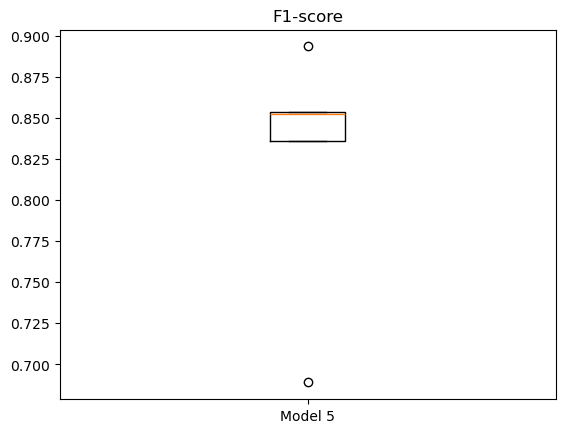

In [19]:
model5 = nn.Sequential(
  nn.Linear(data.shape[1]-1, 50),
  BatchPitNorm1d(num_features=50, num_pit_samples=1000, take_num_samples_when_full=3,
                  normal_backtransform=False, trainable_bandwidths=False, bw_select = "RuleOfThumb", dev=device),
  nn.ReLU(),
  nn.Linear(50, 80),
  nn.ReLU(),
  nn.BatchNorm1d(80),
  nn.Linear(80, 10),
  nn.ReLU(),
  nn.Linear(10, 1))
model5.to(device=device)

acc5, f1_5 = train_model(model5, 5)

plt.boxplot(acc5, labels=["Model 5"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_5, labels=["Model 5"])
plt.title("F1-score")
plt.show()

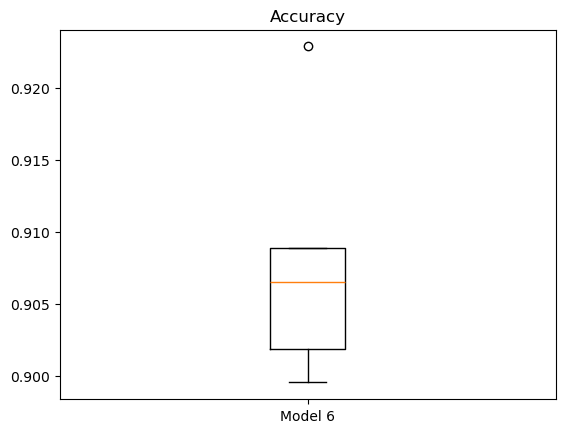

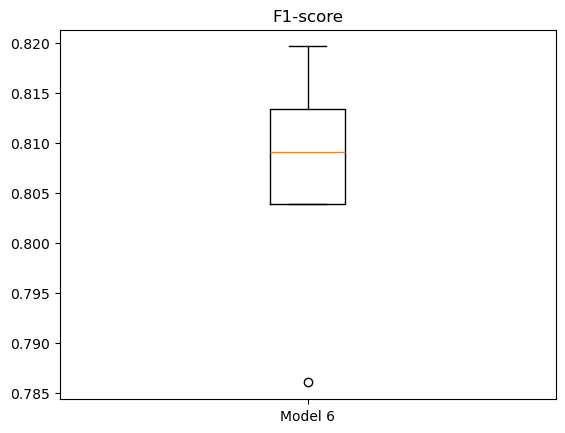

In [21]:
model6 = nn.Sequential(
  nn.Linear(data.shape[1]-1, 100),
  nn.ReLU(),
  nn.BatchNorm1d(100),
  nn.Linear(100, 50),
  nn.Dropout(p=0.3),
  nn.ReLU(),
  nn.Linear(50, 10),
  BatchPitNorm1d(num_features=10, num_pit_samples=1000, take_num_samples_when_full=10,
                  normal_backtransform=False, trainable_bandwidths=False, bw_select = "RuleOfThumb", dev=device),
  nn.ReLU(),
  nn.Linear(10, 1))
model6.to(device=device)

acc6, f1_6 = train_model(model6, 5)

plt.boxplot(acc6, labels=["Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot(f1_6, labels=["Model 6"])
plt.title("F1-score")
plt.show()

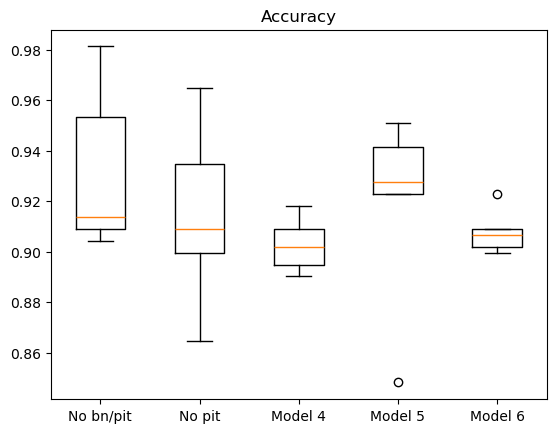

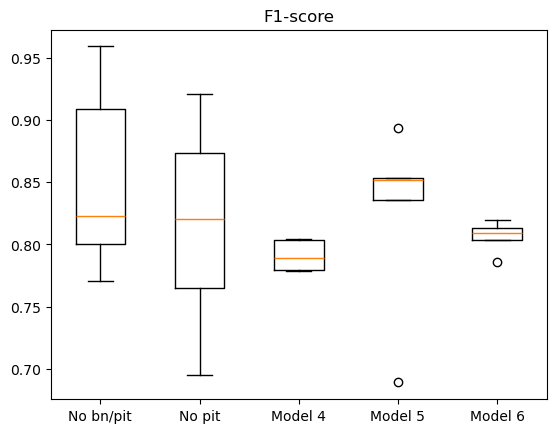

In [22]:
plt.boxplot([acc1, acc2, acc4, acc5, acc6], labels=["No bn/pit", "No pit", "Model 4", "Model 5", "Model 6"])
plt.title("Accuracy")
plt.show()

plt.boxplot([f1_1, f1_2, f1_4, f1_5, f1_6], labels=["No bn/pit", "No pit", "Model 4", "Model 5", "Model 6"])
plt.title("F1-score")
plt.show()